In [1]:
!pip install einops

In [1]:
import torch
from functools import partial

from mmae import *
from utils.plotting import build_mmae_pretraining_dataset, get_random_input_dict # *

%load_ext autoreload
%autoreload 2

# MultiMAE Demo

## 1 Multi-task ImageNet dataset

You can also use any subset of [rgb, depth, semseg] as the input to MultiMAE.
Make sure to standardize the depth inputs if you write your own dataloader.

In [2]:
dataset = build_mmae_pretraining_dataset(
    '/datasets/imagenet_multitask/val/', 
    ['rgb', 'depth', 'semseg_coco'], 
    input_size=224, 
    hflip=0.5
)

## 2 Load pre-trained MultiMAE

This loads the entire MultiMAE with all its input and output adapters.
If you only care about transfer learning, you should instead load a `MultiViT` (see below).

In [3]:
DOMAIN_CONF = {
    'rgb': {
        'input_adapter': partial(PatchedInputAdapter, num_channels=3, stride_level=1),
        'output_adapter': partial(PatchedOutputAdapterXA, num_channels=3, stride_level=1),
        'loss': MaskedMSELoss,
    },
    'depth': {
        'input_adapter': partial(PatchedInputAdapter, num_channels=1, stride_level=1),
        'output_adapter': partial(PatchedOutputAdapterXA, num_channels=1, stride_level=1),
        'loss': MaskedMSELoss,
    },
    'semseg': {
        'input_adapter': partial(SemSegInputAdapter, num_classes=133,
                                 dim_class_emb=64, interpolate_class_emb=False, stride_level=4),
        'output_adapter': partial(PatchedOutputAdapterXA, num_channels=133, stride_level=4),
        'loss': MaskedCrossEntropyLoss,
    },
}

In [4]:
in_domains = 'rgb-depth-semseg'.split('-')
out_domains = 'rgb-depth-semseg'.split('-')
all_domains = '-'.join(set(in_domains) | set(out_domains))

In [5]:
patch_size = 16
dim_tokens_dec = 256
decoder_depth = 2

input_adapters = {
    domain: dinfo['input_adapter'](
        patch_size_full = patch_size,
    )
    for domain, dinfo in DOMAIN_CONF.items()
    if domain in in_domains
}

output_adapters = {
    domain: dinfo['output_adapter'](
        patch_size_full = patch_size,
        dim_tokens = dim_tokens_dec,
        use_task_queries = True,
        depth = decoder_depth,
        context_tasks=in_domains,
        task=domain
    )
    for domain, dinfo in DOMAIN_CONF.items()
    if domain in out_domains
}

/home/memmel/miniconda/envs/pointnav-vo/lib/python3.7/site-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


In [7]:
multimae = pretrain_mmae_base(
    input_adapters=input_adapters,
    output_adapters=output_adapters,
)

In [8]:
ckpt = torch.load('./pretrained/MultiMAE-B-1600.pth', map_location='cpu') # MMAE-B

In [9]:
multimae.load_state_dict(ckpt['model'], strict=False)
multimae = multimae.eval()
multimae = multimae.cuda()

## 3 Masked predictions

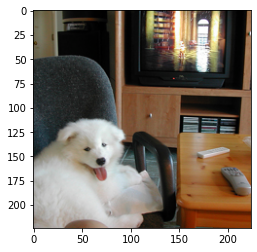

In [6]:
input_dict, _ = get_random_input_dict(dataset, rand_idx=12905, show=True)

In [9]:
input_dict['rgb'].shape, input_dict['depth'].shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 1, 224, 224]))

In [11]:
plot_masked(multimae, input_dict, alphas=1.0, num_encoded_tokens=98, save_path=None)

NameError: name 'plot_masked' is not defined

Here's how that function calls the model under the hood:

In [12]:
with torch.no_grad():
    preds, masks = multimae(input_dict, num_encoded_tokens=98, alphas=1.0)

/home/memmel/miniconda/envs/pointnav-vo/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [13]:
for k,v in preds.items():
    print(k, v.shape)

rgb torch.Size([1, 3, 224, 224])
depth torch.Size([1, 1, 224, 224])
semseg torch.Size([1, 133, 56, 56])


## 4 MultiMAE -> ViT

For training downstream tasks, use the MultiViT module instead.
It doesn't perform any of the masking or shuffling that the MMAE module does.

For example, if you would like to transfer from RGB and depth as input modalities, only create those two as input adapters and load the MultiMAE weights in the same way.
You can specify new downstream task heads by adding them to the output adapters.
If you leave those as `None`, MultiViT will return the encoded tokens.

In [28]:
downstream_modalities = ['rgb', 'depth']

patch_size = 16

input_adapters = {
    domain: dinfo['input_adapter'](
        patch_size_full = patch_size,
    )
    for domain, dinfo in DOMAIN_CONF.items()
    if domain in downstream_modalities
}

In [29]:
multimae_vit = multivit_base(
    input_adapters=input_adapters,
    output_adapters=None,
)

In [30]:
multimae_vit.load_state_dict(ckpt['model'], strict=False)
multimae_vit = multimae_vit.eval()
multimae_vit = multimae_vit.cuda()

In [31]:
with torch.no_grad():
    preds = multimae_vit(input_dict)

In [18]:
preds.shape # B x N_tokens x token_dim. preds[:,-1,:] are the "global" tokens, similar to cls tokens in ViT

torch.Size([1, 393, 768])

In [19]:
preds[:,-1,:].shape # "general" tokens

torch.Size([1, 768])

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(multimae_vit)

85843200

In [35]:
input_dict['depth'].shape

torch.Size([1, 1, 224, 224])